# RAIDIUM MEDICAL ORGANS CLUSTERING PROJECT

## Imports

In [1]:
!lscpu

Architecture:             x86_64
  CPU op-mode(s):         32-bit, 64-bit
  Address sizes:          46 bits physical, 48 bits virtual
  Byte Order:             Little Endian
CPU(s):                   4
  On-line CPU(s) list:    0-3
Vendor ID:                GenuineIntel
  Model name:             Intel(R) Xeon(R) CPU @ 2.00GHz
    CPU family:           6
    Model:                85
    Thread(s) per core:   2
    Core(s) per socket:   2
    Socket(s):            1
    Stepping:             3
    BogoMIPS:             4000.46
    Flags:                fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge m
                          ca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht sysc
                          all nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xt
                          opology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq
                           ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt
                           aes xsave avx f16c rdrand hypervisor 

In [2]:
!pip3 install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126
!pip -q install iterative-stratification

In [3]:
import tensorflow as tf  
# Check if GPU is available
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

# Ensure TensorFlow uses GPU
tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)

Num GPUs Available: 1


## Fetching dataset

In [4]:
!wget https://challengedata.ens.fr/media/public/label_Hnl61pT.csv -O y_train.csv

--2025-02-27 09:24:53--  https://challengedata.ens.fr/media/public/label_Hnl61pT.csv
Resolving challengedata.ens.fr (challengedata.ens.fr)... 129.199.99.148
Connecting to challengedata.ens.fr (challengedata.ens.fr)|129.199.99.148|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 267819968 (255M) [text/csv]
Saving to: ‘y_train.csv’

y_train.csv         100%[===================>] 255.41M  10.5MB/s    in 49s     

2025-02-27 09:25:44 (5.16 MB/s) - ‘y_train.csv’ saved [267819968/267819968]



In [5]:
# downloading the images

!wget https://challengedata.ens.fr/media/public/train-images.zip
!wget  https://challengedata.ens.fr/media/public/test-images.zip
!wget https://challengedata.ens.fr/media/public/annotated_labels.json

--2025-02-27 09:25:45--  https://challengedata.ens.fr/media/public/train-images.zip
Resolving challengedata.ens.fr (challengedata.ens.fr)... 129.199.99.148
Connecting to challengedata.ens.fr (challengedata.ens.fr)|129.199.99.148|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52391647 (50M) [application/zip]
Saving to: ‘train-images.zip.1’

train-images.zip.1  100%[===================>]  49.96M  9.06MB/s    in 6.3s    

2025-02-27 09:25:53 (7.93 MB/s) - ‘train-images.zip.1’ saved [52391647/52391647]

--2025-02-27 09:25:53--  https://challengedata.ens.fr/media/public/test-images.zip
Resolving challengedata.ens.fr (challengedata.ens.fr)... 129.199.99.148
Connecting to challengedata.ens.fr (challengedata.ens.fr)|129.199.99.148|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12803342 (12M) [application/zip]
Saving to: ‘test-images.zip.1’

test-images.zip.1   100%[===================>]  12.21M  4.45MB/s    in 2.7s    

2025-02-27 09:25:57 

In [6]:
# Unzip images

!unzip -q -n train-images.zip
!unzip -q -n test-images.zip

In [7]:
import pandas as pd 

# Load the train labels
# Note the transpose!
labels_train = pd.read_csv("y_train.csv", index_col=0).T

In [8]:
# load annotated_labels.json
import json 

with open("annotated_labels.json", "r") as f:
    annotated_labels = json.load(f)

In [9]:
# Here is a function to load the data
def load_dataset(dataset_dir):
    dataset_list = []
    # Note: It's very important to load the images in the correct numerical order!
    for image_file in list(sorted(Path(dataset_dir).glob("*.png"), key=lambda filename: int(filename.name.rstrip(".png")))):
        dataset_list.append(cv2.imread(str(image_file), cv2.IMREAD_GRAYSCALE))
    return np.stack(dataset_list, axis=0)

In [10]:
!pip install cv

In [11]:
from pathlib import Path
import cv2
import numpy as np

# Load the train and test sets
# If you've put the shortcut directly in your drive, this should work out of the box
# Else, edit the path
data_dir = Path("./")
data_train = load_dataset(data_dir / "train-images")
data_test = load_dataset(data_dir / "test-images")

## Visualize dataset

In [12]:
labels_train

,Pixel 0,Pixel 1,Pixel 2,Pixel 3,Pixel 4,Pixel 5,Pixel 6,Pixel 7,Pixel 8,Pixel 9,...,Pixel 65526,Pixel 65527,Pixel 65528,Pixel 65529,Pixel 65530,Pixel 65531,Pixel 65532,Pixel 65533,Pixel 65534,Pixel 65535
0.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1996.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1997.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1998.png,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# Each image in annotated_labels contains 27 clusters,
# only some of these were actually annotated pixel by pixel in labels_train
# hence most cluster ids are not represented on most images and replaced by 0s..

df_annotated_labels = pd.DataFrame(annotated_labels).fillna(-1)
df_annotated_labels.index = [f"{i}.png" for i in range(len(annotated_labels))]  # Add .png extension

df_annotated_labels

# -1 means empty value... basically 1200 images do not have clusters?

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
0.png,2.0,4.0,8.0,10.0,11.0,12.0,13.0,14.0,15.0,18.0,...,32.0,36.0,44.0,46.0,47.0,49.0,50.0,52.0,53.0,54.0
1.png,4.0,6.0,10.0,11.0,12.0,13.0,15.0,17.0,19.0,21.0,...,37.0,42.0,45.0,46.0,47.0,48.0,49.0,51.0,53.0,54.0
2.png,2.0,3.0,6.0,7.0,8.0,9.0,11.0,12.0,16.0,18.0,...,33.0,34.0,36.0,38.0,39.0,42.0,44.0,49.0,50.0,54.0
3.png,1.0,6.0,7.0,12.0,16.0,17.0,20.0,21.0,23.0,24.0,...,36.0,38.0,41.0,43.0,47.0,48.0,51.0,52.0,53.0,54.0
4.png,4.0,5.0,9.0,11.0,12.0,13.0,15.0,17.0,20.0,22.0,...,39.0,40.0,41.0,43.0,44.0,45.0,48.0,50.0,52.0,54.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995.png,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1996.png,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1997.png,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1998.png,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [14]:
# The train data is a numpy array of 1000 images of 512*512
print(f"X_train shape: {data_train.shape}")
# The train label is a dataframe of 1000 rows with 262144 (=512x512) columns
print(f"Y_train shape: {labels_train.shape}")

X_train shape: (2000, 256, 256)
Y_train shape: (2000, 65536)


In [15]:
# Let's display some data
# Here is a function to display side by side a slide and a segmented mask
def plot_slice_seg(slice_image, seg):
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(slice_image, cmap="gray")
    axes[1].imshow(slice_image, cmap="gray")
    seg_masked = np.ma.masked_where(seg.reshape((256,256)) == 0, (seg.reshape((256,256))))
    axes[1].imshow(seg_masked, cmap="tab20")
    plt.axis("off")

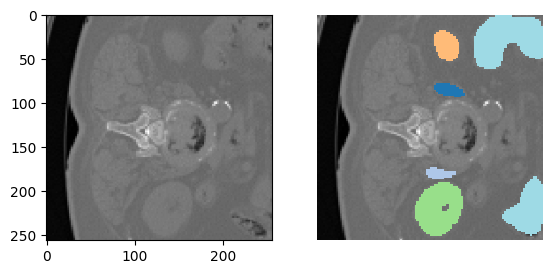

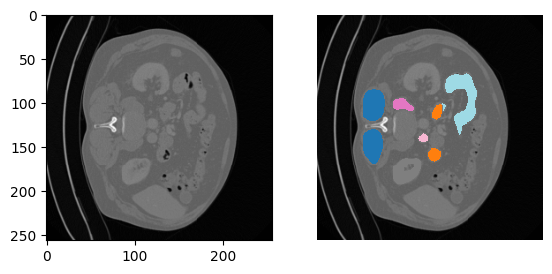

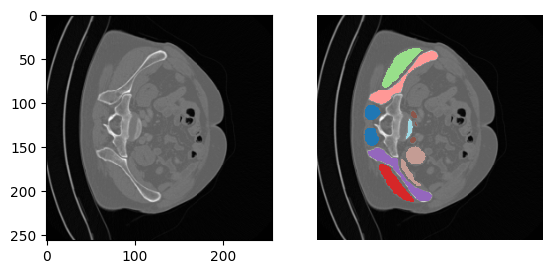

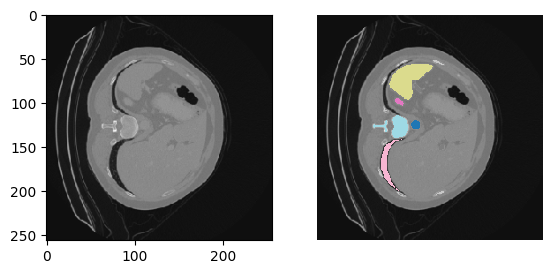

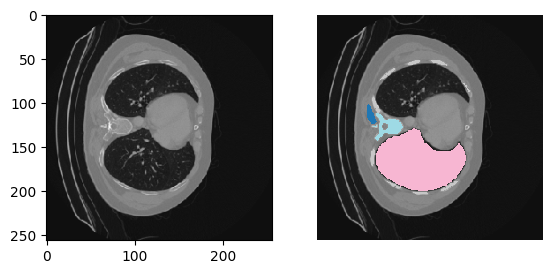

In [16]:
# Let's try it on some slides and their segmentation masks
# Note: we have to reshape the rows of the dataframe into a 256*256 matrix
import matplotlib.pyplot as plt

for i in range(10, 15):
  plot_slice_seg(data_train[i], labels_train.iloc[i].values.reshape((256,256)))

## Dataset analysis

In [17]:
# Boolean mask for rows that contain only zeros
zero_rows = labels_train.eq(0).all(axis=1)

# Count rows that contain only zeros (unannotated images)
unannotated_labels_train = zero_rows.sum()

print(f"Number of unannotated images in labels_train: {unannotated_labels_train}")

Number of unannotated images in labels_train: 1241


In [18]:
# Boolean mask for rows that contain at least one nonzero pixel
annotated_rows = labels_train.ne(0).any(axis=1)

# Filter only the 800 images with labeled structures
labels_train_annotated = labels_train[annotated_rows]

# Print the number of remaining images
print(f"Number of annotated images in labels_train: {labels_train_annotated.shape[0]}")

Number of annotated images in labels_train: 759


In [19]:
# Count the number of images with empty lists (unannotated)
unannotated_json = sum(len(labels) == 0 for labels in annotated_labels)

print(f"Number of unannotated images in annotated_labels.json: {unannotated_json}")

Number of unannotated images in annotated_labels.json: 1200


In [20]:
# Count the number of images with empty lists (unannotated)
annotated_json = sum(len(labels) > 0 for labels in annotated_labels)

print(f"Number of annotated images in annotated_labels.json: {annotated_json}")

Number of annotated images in annotated_labels.json: 800


In [21]:
# Get list of all image names in labels_train that are fully zero
unannotated_labels_train_set = set(labels_train.index[zero_rows])

# Get list of all unannotated image names from JSON
unannotated_json_set = {f"{i}.png" for i, labels in enumerate(annotated_labels) if len(labels) == 0}

# Find the extra unannotated images in labels_train (but not in JSON)
extra_unannotated_in_csv = unannotated_labels_train_set - unannotated_json_set

print(f"Number of extra unannotated images in labels_train: {len(extra_unannotated_in_csv)}")
print(extra_unannotated_in_csv)

Number of extra unannotated images in labels_train: 41
{'5.png', '709.png', '232.png', '282.png', '148.png', '682.png', '768.png', '496.png', '152.png', '254.png', '184.png', '460.png', '567.png', '28.png', '237.png', '127.png', '67.png', '61.png', '27.png', '771.png', '753.png', '128.png', '397.png', '751.png', '399.png', '134.png', '594.png', '640.png', '214.png', '48.png', '202.png', '45.png', '395.png', '532.png', '321.png', '765.png', '639.png', '231.png', '467.png', '203.png', '562.png'}


In [22]:
# Labels are 0 for background and 1 to 54 for all organs
print(sorted(labels_train.stack().unique()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54]


In [23]:
# Example

image_id = 39
labels_for_image = annotated_labels[image_id]

print(f"{len(labels_for_image)} annotated labels for image {image_id}.png: {labels_for_image}")

27 annotated labels for image 39.png: [1, 2, 4, 7, 10, 11, 12, 15, 16, 17, 21, 24, 26, 28, 31, 32, 39, 40, 41, 43, 44, 47, 48, 49, 50, 52, 54]


In [24]:
# less labels actually present in labels_train... others replaced by 0s...
labels_train.loc["39.png"].value_counts()

39.png
0     64361
54      681
4       233
43      226
11       35
Name: count, dtype: int64

In [25]:
print(f"Number of annotated images in labels_train: {labels_train_annotated.shape[0]}")

# Get the indices (or filenames) of annotated images.
# (Assuming that the index of labels_df is the image filename, e.g. "0.png", "1.png", etc.)
annotated_filenames = labels_train_annotated.index.tolist()
print("Annotated filenames (first 10):", annotated_filenames[:10])

Number of annotated images in labels_train: 759
Annotated filenames (first 10): ['0.png', '1.png', '2.png', '3.png', '4.png', '6.png', '7.png', '8.png', '9.png', '10.png']


1        926
2        673
3     115092
4     208579
5     201305
6     283963
7       4723
8       4422
9     247582
10     19671
11     17542
12    320273
13      7937
14      6131
15      7501
16     65158
17     55008
18     63491
19     68319
20     11931
21     14037
22    330252
23     90404
24     76409
25      1977
26      1859
27      4612
28      5045
29      9206
30      6423
31     87612
32     86498
33     28015
34     47374
35     55493
36    550923
37    781124
38    925175
39     20693
40      5564
41     36685
42     53261
43     50937
44     76503
45     17677
46     14275
47    315423
48     72506
49    111266
50     13885
51     28022
52     51741
53    110911
54    159006
Name: count, dtype: int64


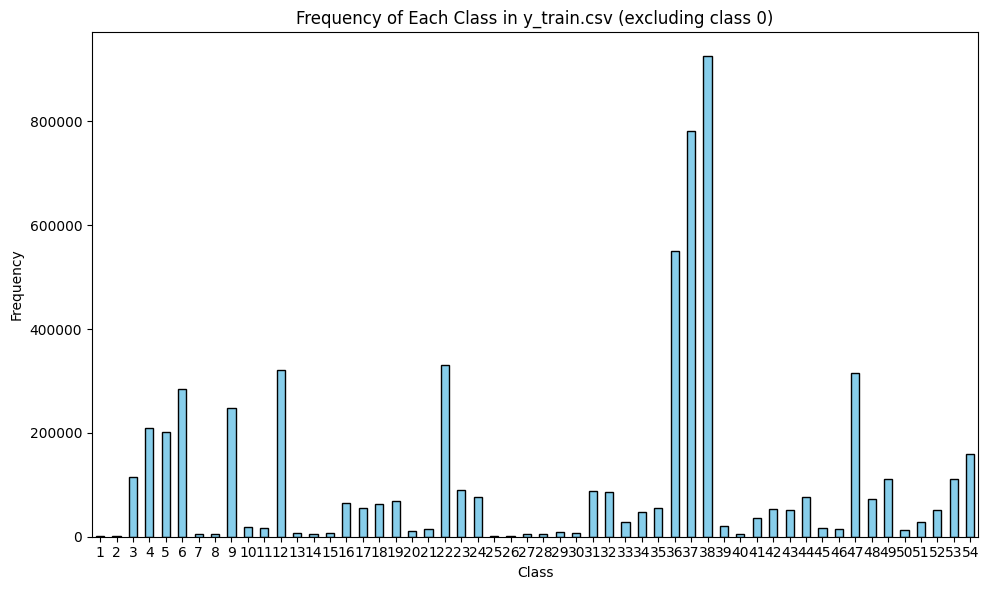

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming labels_train is already loaded, for example:
# labels_train = pd.read_csv("y_train.csv", index_col=0).T

# Flatten all values and compute frequency counts
all_values = labels_train.values.flatten()
frequency = pd.Series(all_values).value_counts().sort_index()

# Exclude class 0
if 0 in frequency.index:
    frequency = frequency.drop(0)

print(frequency)

# Create a bar chart
plt.figure(figsize=(10, 6))
frequency.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Frequency of Each Class in y_train.csv (excluding class 0)")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## Segformer

In [27]:
import pandas as pd

# Read the entire CSV and select only 10 random rows
train_df = pd.read_csv("y_train.csv", index_col=0).sample(n=30, axis=1, random_state=42)

# Save the selected subset to a new CSV file
train_df.to_csv("y_train_sampled.csv", index=True)

print("Saved y_train_sampled.csv with shape:", train_df.shape)

Saved y_train_sampled.csv with shape: (65536, 30)


In [28]:
import pandas as pd
from pathlib import Path
import cv2
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import sklearn.metrics
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation, SegformerConfig, SegformerModel
import torch
import random
from scipy.optimize import linear_sum_assignment
import albumentations as A
from torch.utils.data import DataLoader
import os
import gc
from torchmetrics import MeanMetric
from sklearn.model_selection import StratifiedKFold, KFold
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from scipy.spatial.distance import cdist

# Set random seed for reproducibility
seed = 12458
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

TRAIN = True
N_EPOCHS = 5000
BATCH_SIZE = 8
MODEL_NAME = "nvidia/mit-b4"

# Load the train labels; note the transpose!
train_df = pd.read_csv("y_train.csv", index_col=0).T
print(train_df.shape)
MAX_ITEMS = 55
mask = ~(train_df.values == 0).all(axis=-1)
train_df = train_df[mask]
print("Train data shape:", train_df.shape)

# Define augmentations using Albumentations
transform = A.Compose([
    A.GaussNoise(),
    A.OneOf([
        A.MotionBlur(p=0.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45,
                       border_mode=cv2.BORDER_CONSTANT, p=0.3),
    A.HorizontalFlip(p=0.5),  # Use explicit Flip augmentations
    A.VerticalFlip(p=0.5),
    A.ElasticTransform(p=0.2),
    A.RandomBrightnessContrast(p=0.2),
])

# Dataset definition
class MyDataset():
    def __init__(self, train_df) -> None:
        self.paths = list(train_df.index)
        self.targets = train_df.values.astype(np.uint8)
        # No additional initialization needed

    def __getitem__(self, i):
        path = f"train-images/{self.paths[i]}"
        x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  # (256, 256)
        y = self.targets[i].reshape(256, 256)         # (256, 256)
        # Apply augmentation
        transformed = transform(image=x, mask=y)
        x = transformed['image']
        y = transformed['mask']
        # x: (1, 256, 256) and y: one-hot encoded tensor (MAX_ITEMS, 256, 256)
        return x[np.newaxis], self.one_hot(y)
    
    def one_hot(self, y):
        # Create one-hot masks for each unique label
        y = [y == x for x in np.unique(y)]
        # Separate background (first channel) and foreground channels
        y_ = y[1:]
        # Shuffle the foreground channels to avoid fixed ordering
        random.shuffle(y_)
        y = np.stack(y[:1] + y_)
        # Pad to MAX_ITEMS channels if necessary
        y = np.pad(y, [(0, MAX_ITEMS - y.shape[0]), (0, 0), (0, 0)])
        return y.astype(np.float32)
    
    def __len__(self):
        return len(self.paths)

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.4 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


(2000, 65536)
Train data shape: (759, 65536)


/usr/local/lib/python3.10/dist-packages/albumentations/core/validation.py:45: UserWarning: This augmenter is very slow. Try to use ``ElasticTransformation`` instead, which is at least 10x faster.
  original_init(self, **validated_kwargs)


In [29]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

# Suppose train_df is your DataFrame containing image names as index and 
# the segmentation labels as values (flattened or not) as read from your CSV.
# We'll create a multi-label indicator matrix where each row corresponds 
# to an image and each column corresponds to one of the 55 classes.

# For each image, compute a binary vector indicating presence/absence of each class.
def compute_label_vector(row, max_items=55):
    # Get the unique labels present in the row (assumes background is 0)
    labels = np.unique(row.values)
    # Create a binary vector of length max_items
    vec = np.zeros(max_items, dtype=int)
    # For each label (assuming labels are in [0, max_items-1]),
    # mark as present (if label > 0, e.g., skipping background if desired)
    for lbl in labels:
        # Optionally skip background (if background is 0 and you don't want to stratify on it)
        if lbl != 0:
            vec[int(lbl)] = 1
    return vec

# Compute the multi-label indicator for each image
multi_labels = np.stack([compute_label_vector(train_df.loc[name]) for name in train_df.index])

# Now use MultilabelStratifiedKFold to create a split.
mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
train_indices, val_indices = next(mskf.split(np.zeros(len(train_df)), multi_labels))

# Create separate DataFrames for train and validation.
train_df_split = train_df.iloc[train_indices]
val_df_split = train_df.iloc[val_indices]

print("Train split shape:", train_df_split.shape)
print("Validation split shape:", val_df_split.shape)

# Create separate datasets / data loaders
train_dataset = MyDataset(train_df_split)
val_dataset = MyDataset(val_df_split)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=16,
    shuffle=True
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    num_workers=16,
    shuffle=False  # typically no shuffling for validation
)

Train split shape: (608, 65536)
Validation split shape: (151, 65536)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [44]:
print("Train split contains: ", len(train_df_split.stack().unique()), " - Val split contains: ", len(val_df_split.stack().unique()))

Train split contains:  55  - Val split contains:  55


In [36]:
# Dice Loss definition
class DiceLoss(torch.nn.Module):
    def __init__(self,):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1e-10):
        # Flatten tensors: both become vectors of shape (B * MAX_ITEMS * 256*256,)
        inputs, targets = inputs.contiguous().view(-1), targets.contiguous().view(-1)
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)
        return 1 - dice  # scalar

# Matching Loss definition modified to return a tuple (ce_loss, dice_loss)
class MatchingLoss(torch.nn.Module):
    def __init__(self,):
        super(MatchingLoss, self).__init__()
        # Cross entropy function expects raw logits (it applies softmax internally)
        self.loss_fn1 = torch.nn.functional.cross_entropy
        self.loss_fn2 = DiceLoss()
    
    def forward(self, inputs, targets):
        # inputs: (B, MAX_ITEMS, 256, 256) logits; targets: (B, MAX_ITEMS, 256, 256) one-hot masks
        # Reshape to flatten spatial dimensions: (B, MAX_ITEMS, 256*256)
        inputs = inputs.view(*inputs.size()[:2], -1)
        targets = targets.view(*targets.size()[:2], -1)

        # Remove the background channel (index 0)
        bg_inputs, bg_targets = inputs[:, :1], targets[:, :1]  # (B, 1, 256*256)
        inputs, targets = inputs[:, 1:], targets[:, 1:]           # (B, MAX_ITEMS-1, 256*256)

        # Compute best matching loss between foreground channels using L1 cost
        costs = torch.cdist(inputs, targets, p=1).detach().cpu().numpy()  # (B, MAX_ITEMS-1, MAX_ITEMS-1)
        inputs_arr, targets_arr = [], []
        for i in range(len(costs)):  # loop over batch (B)
            inputs_, targets_ = inputs[i], targets[i]  # each: (MAX_ITEMS-1, 256*256)
            l, k = linear_sum_assignment(costs[i])  # optimal matching indices for foreground channels
            inputs_arr.append(inputs_[l])   # reorder channels: (MAX_ITEMS-1, 256*256)
            targets_arr.append(targets_[k])  # reorder channels: (MAX_ITEMS-1, 256*256)
        inputs = torch.stack(inputs_arr)    # (B, MAX_ITEMS-1, 256*256)
        targets = torch.stack(targets_arr)   # (B, MAX_ITEMS-1, 256*256)

        # Add background channel back
        inputs = torch.cat([bg_inputs, inputs], 1)   # Final shape: (B, MAX_ITEMS, 256*256)
        targets = torch.cat([bg_targets, targets], 1)  # Final shape: (B, MAX_ITEMS, 256*256)

        # For cross entropy, convert one-hot targets to indices (each pixel: integer in [0, MAX_ITEMS-1])
        target_indices = torch.argmax(targets, dim=1)  # shape: (B, 256*256)

        ce_loss = self.loss_fn1(inputs, target_indices)
        dice_loss = self.loss_fn2(torch.softmax(inputs, dim=1), targets)
        return ce_loss, dice_loss

# LightningModule definition with TensorBoard logging and epoch-level logging using the loss_fn outputs.
class MyModel(pl.LightningModule):
    def __init__(self, in_channels=1):
        super().__init__()

        # Load the config of the pretrained nvidia/mit-b* model
        config = SegformerConfig.from_pretrained(MODEL_NAME)
        config.num_channels = in_channels  # 1 for grayscale
        config.id2label = {i: i for i in range(MAX_ITEMS)}
        config.label2id = {i: i for i in range(MAX_ITEMS)}
        self.config = config
        # Create a randomly initialized model from the config
        self.backbone = SegformerForSemanticSegmentation(config)
        
        self.loss_fn = MatchingLoss()
        self.mean_tracker = MeanMetric()

    def forward(self, img):
        # img shape: (B, 1, 256, 256)
        img = img / 255
        out = self.backbone(pixel_values=img)[0]  # (B, MAX_ITEMS, 64, 64) downsampled (example)
        out = torch.nn.functional.interpolate(out, mode='bilinear', scale_factor=4)  # upsample to (B, MAX_ITEMS, 256, 256)
        return out

    def training_step(self, batch, batch_idx):
        x, y = batch  # x: (B, 1, 256, 256); y: (B, MAX_ITEMS, 256, 256)
        y_hat = self(x)  # y_hat: (B, MAX_ITEMS, 256, 256)
        ce_loss, dice_loss = self.loss_fn(y_hat, y)  # each is a scalar loss
        loss = ce_loss + dice_loss
        
        # Compute dice score from dice_loss
        dice_score = 1 - dice_loss
        
        # Log metrics (on_epoch=True aggregates over the epoch)
        self.log("train_loss", loss, prog_bar=True, on_epoch=True)
        self.log("train_ce_loss", ce_loss, prog_bar=True, on_epoch=True)
        self.log("train_dice_score", dice_score, prog_bar=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        ce_loss, dice_loss = self.loss_fn(y_hat, y)
        loss = ce_loss + dice_loss
        
        # Compute dice score from dice_loss
        dice_score = 1 - dice_loss
        
        self.log("val_loss", loss, prog_bar=True, on_epoch=True)
        self.log("val_ce_loss", ce_loss, prog_bar=True, on_epoch=True)
        self.log("val_dice_score", dice_score, prog_bar=True, on_epoch=True)
        return {"val_loss": loss, "val_ce_loss": ce_loss, "val_dice_score": dice_score}

    def on_train_epoch_end(self):
        # Reset the mean tracker at the end of each epoch
        self.mean_tracker.reset()

    def on_validation_epoch_end(self):
        # No extra aggregation is required here since we log on_epoch in each step.
        pass

    def configure_optimizers(self):
        LR = 1e-4
        self.optimizer = torch.optim.Adam(self.parameters(), lr=LR)
        self.reduce_lr_on_plateau = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='min',
            factor=0.7,
            patience=10,
            min_lr=1e-6,
            verbose=True
        )
        return {"optimizer": self.optimizer, "lr_scheduler": self.reduce_lr_on_plateau, "monitor": "train_loss"}

# Set up TensorBoard logger for online logging
from pytorch_lightning.loggers import TensorBoardLogger
logger = TensorBoardLogger("tb_logs", name="segform")

# Device selection
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

TRAIN = True

if TRAIN:
    model = MyModel()

    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        dirpath="models/",
        filename="model",
        save_top_k=1,
        monitor="train_loss",
        mode="min",
        every_n_epochs=1,
        save_weights_only=True,
        verbose=True
    )
    stopping_callback = EarlyStopping(monitor="train_loss", mode="min", patience=1000)
    accelerator = "gpu" if torch.cuda.is_available() else "cpu"

    trainer = pl.Trainer(
        max_epochs=N_EPOCHS,
        accelerator="gpu",
        devices="auto",
        accumulate_grad_batches=2,
        num_sanity_val_steps=0,
        callbacks=[checkpoint_callback, stopping_callback],
        logger=logger
    )
    # Provide both train and validation dataloaders
    trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /kaggle/working/models exists and is not empty.
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training: |          | 0/? [00:00<?, ?it/s]

NameError: name 'exit' is not defined